In [1]:
import torch
import numpy as np
from shape_space import PreShapeSpace, ShapeSpace
from manifold_pca import ManifoldPCA
from sklearn.decomposition import PCA
from stats import optimize_frechet_mean, iterate_frechet_mean
import matplotlib.pyplot as plt
from pathlib import Path
import aist_helpers
from matplotlib import cm

%matplotlib widget

## Load data from AIST++

In [2]:
data_source = Path('data') / 'aist'

# poses = (720, 17, 3), i.e. a set of 720 shapes
poses = aist_helpers.load_poses(data_source / 'gBR_sBM_cAll_d04_mBR0_ch06.pkl')

# Initial standardization ("projecting points onto the manifold of PreShapeSpace")
poses = poses - torch.mean(poses, dim=1, keepdims=True)
poses = poses / torch.linalg.norm(poses.reshape(-1, 17*3), dim=-1)[:, None, None]

/var/folders/ph/lx9dyyx91893rxnlw09n7t0c0000gn/T/ipykernel_69735/176306336.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma')


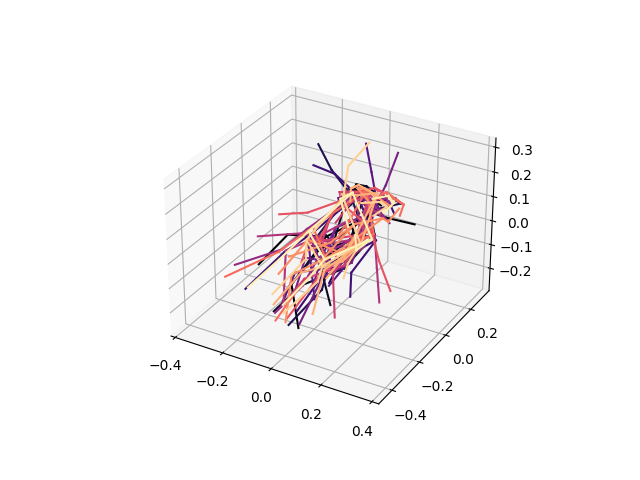

In [3]:
cmap = cm.get_cmap('magma')

plt.clf()
ax = plt.subplot(111, projection='3d')
for i, p in enumerate(poses):
    if i % 50 == 0:
        aist_helpers.plot_bones(p, ax, color=cmap(i / len(poses)))
plt.axis('equal')
plt.show()

## Make manifold objects for handling poses as PreShapes or Shapes

Recall that PreShapeSpace accounts for scale and shift constraints only. ShapeSpace then additionally removes rotations.

In [9]:
pre_shape_space = PreShapeSpace(num_keypoints=17, keypoints_dim=3)
shape_space = ShapeSpace(num_keypoints=17, keypoints_dim=3)

Confirm that earlier comment about subtracting the mean and normalizing is equivalent to "projecting onto the PreShapeSpace manfiold":

In [16]:
assert torch.allclose(poses, torch.stack([pre_shape_space.project(p) for p in poses], dim=0))

__Calculate the mean pose of some movement__

naive mean pose is a tensor with shape torch.Size([17, 3])
frechet mean (pre shape space) point is a tensor with shape torch.Size([17, 3])
frechet mean (shape space) point is a tensor with shape torch.Size([17, 3])


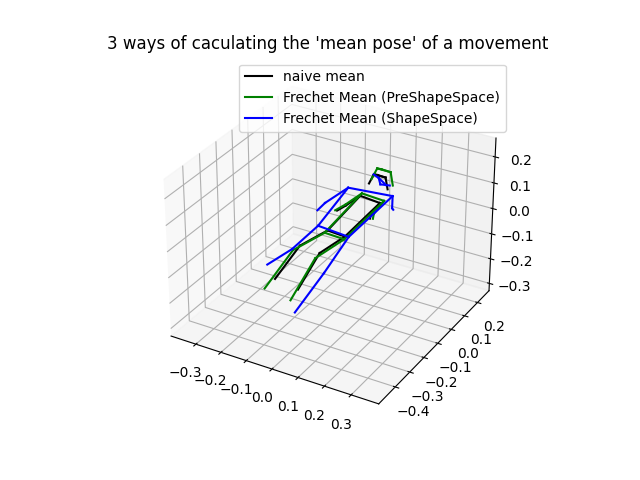

In [17]:
mean_pose_naive = torch.mean(poses, dim=0)
print("naive mean pose is a tensor with shape", mean_pose_naive.shape)

frechet_mean_pre = iterate_frechet_mean(pre_shape_space, poses)
print("frechet mean (pre shape space) point is a tensor with shape", frechet_mean_pre.shape)

frechet_mean_shape = iterate_frechet_mean(shape_space, poses)
print("frechet mean (shape space) point is a tensor with shape", frechet_mean_shape.shape)

# For plotting purposes, align ShapeSpace mean (which is rotation-invariant) to the PreShapeSpace mean
_, frechet_mean_shape = ShapeSpace.align(frechet_mean_pre, frechet_mean_shape, anchor="x")

plt.figure()
ax = plt.subplot(111, projection='3d')
aist_helpers.plot_bones(mean_pose_naive, ax, color='k', label='naive mean')
aist_helpers.plot_bones(frechet_mean_pre, ax, color='g', label='Frechet Mean (PreShapeSpace)')
aist_helpers.plot_bones(frechet_mean_shape, ax, color='b', label='Frechet Mean (ShapeSpace)')
plt.legend()
plt.title("3 ways of caculating the 'mean pose' of a movement")
plt.axis('equal')
plt.show()

## Do PCA on a single movement sequence

/Users/richard/Research/notes/lab-teaching-geometry-shape-space/manifold_pca.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


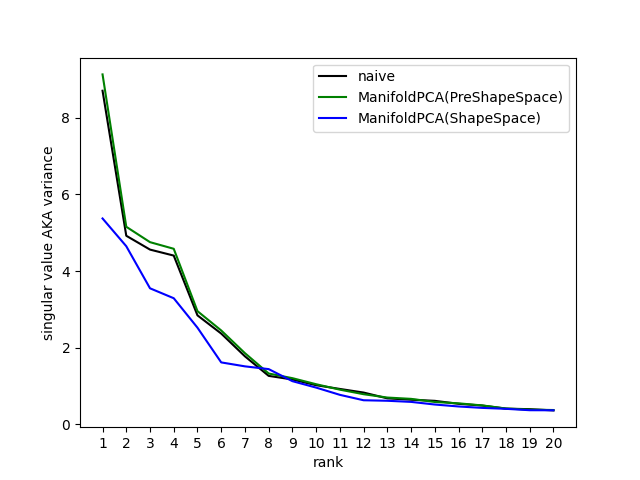

In [20]:
naive_pca = PCA(n_components=20)
naive_pca.fit(poses.reshape(-1, 17*3))

mani_pca_pre = ManifoldPCA(pre_shape_space, n_components=20)
mani_pca_pre.fit(poses)

mani_pca_shape = ManifoldPCA(shape_space, n_components=20)
mani_pca_shape.fit(poses)

rank = np.arange(20)+1

plt.figure()
plt.plot(rank, naive_pca.singular_values_, color='k', label='naive')
plt.plot(rank, mani_pca_pre.singular_values_, color='g', label='ManifoldPCA(PreShapeSpace)')
plt.plot(rank, mani_pca_shape.singular_values_, color='b', label='ManifoldPCA(ShapeSpace)')

plt.xlabel('rank')
plt.ylabel('singular value AKA variance')
plt.xticks(rank)
plt.legend()
plt.show()

/Users/richard/Research/notes/lab-teaching-geometry-shape-space/manifold_pca.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


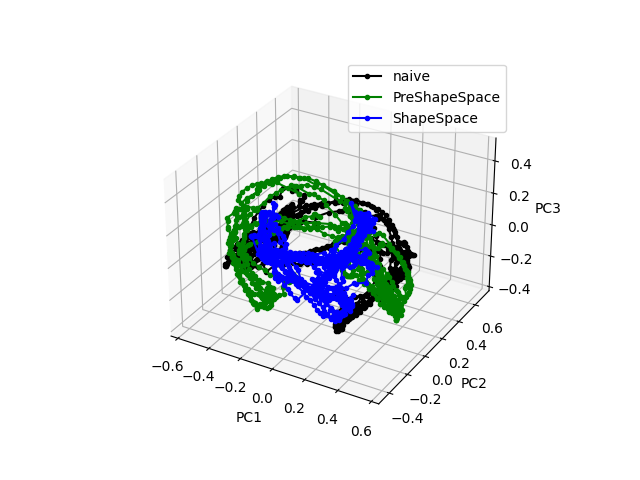

In [23]:
naive_pca_transformed = naive_pca.transform(poses.reshape(-1, 17*3))
mani_pca_pre_transformed = mani_pca_pre.transform(poses)
mani_pca_shape_transformed = mani_pca_shape.transform(poses)

plt.figure()
ax = plt.subplot(111, projection='3d')
ax.plot(naive_pca_transformed[:, 0], naive_pca_transformed[:, 1], naive_pca_transformed[:, 2], '-k', marker='.', label='naive')
ax.plot(mani_pca_pre_transformed[:, 0], mani_pca_pre_transformed[:, 1], mani_pca_pre_transformed[:, 2], '-g', marker='.', label='PreShapeSpace')
ax.plot(mani_pca_shape_transformed[:, 0], mani_pca_shape_transformed[:, 1], mani_pca_shape_transformed[:, 2], '-b', marker='.', label='ShapeSpace')
plt.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.axis('equal')
plt.show()